Shape : (12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


None


Missing values (non-zero):
rating    230
genre      62
type       25
dtype: int64

After cleaning → shape: (12294, 7)
Total remaining NaNs: 0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
anime_id,12294.0,NaN,NaN,NaN,14058.221653,11455.294701,1.0,3484.25,10260.5,24794.5,34527.0
name,12294,12292,Saru Kani Gassen,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genre,12294,3265,Hentai,823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,12294,7,TV,3787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
episodes,12294.0,NaN,NaN,NaN,12.095412,46.244062,1.0,1.0,2.0,12.0,1818.0
rating,12294.0,NaN,NaN,NaN,6.4757,1.017179,1.67,5.9,6.57,7.17,10.0
members,12294.0,NaN,NaN,NaN,18071.338864,54820.676925,5.0,225.0,1550.0,9437.0,1013917.0


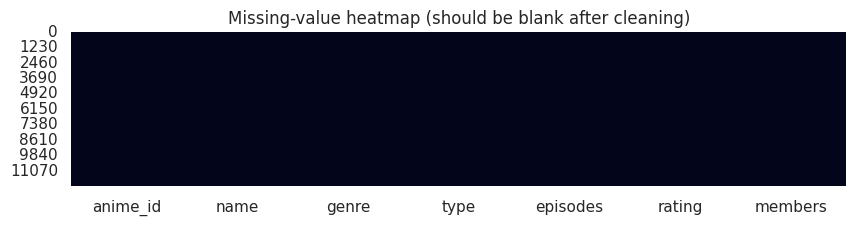

In [ ]:
# ======================================================================
# Anime Recommendation – Task 1: Data Pre-processing & Quick EDA
# ======================================================================

# 0️⃣  Install a helper library for nice visuals (seaborn); pandas is pre-installed in Colab
!pip install -q seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# 1️⃣  Load the dataset ---------------------------------------------------------
df = pd.read_csv("anime.csv")        # <-- make sure anime.csv is in /content

print("Shape :", df.shape)
display(df.head())                   # peek at first rows
display(df.info())

# 2️⃣  Inspect missing values ---------------------------------------------------
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values (non-zero):")
print(missing[missing > 0])

# 3️⃣  Basic cleaning / handling NAs --------------------------------------------
# (Feel free to adjust to your project’s needs)

# Convert numeric-looking columns that may be stored as object
for col in ["rating", "episodes", "members"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows missing the anime title (critical field)
df = df.dropna(subset=["name"]) if "name" in df.columns else df

# Fill numeric NaNs with column median
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill remaining object NaNs with "Unknown"
obj_cols = df.select_dtypes(exclude=np.number).columns
df[obj_cols] = df[obj_cols].fillna("Unknown")

print("\nAfter cleaning → shape:", df.shape)
print("Total remaining NaNs:", df.isna().sum().sum())

# 4️⃣  Quick descriptive statistics --------------------------------------------
display(df.describe(include="all").T)

# 5️⃣  Visual overview of any residual missingness -----------------------------
plt.figure(figsize=(10, 2))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing-value heatmap (should be blank after cleaning)")
plt.show()


In [ ]:
# ======================================================================
# Anime Recommendation – Task 2: Feature Extraction
# ======================================================================

# 0️⃣  Installs (if scikit-learn not yet available in your Colab runtime)
!pip install -q scikit-learn seaborn

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import seaborn as sns

sns.set_theme(style="whitegrid")

# 1️⃣  Load & minimal clean ----------------------------------------------------
df = pd.read_csv("anime.csv")        # <-- ensure file is uploaded

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Rename common columns to predictable names (adjust if your file differs)
rename_map = {
    "anime_id": "anime_id",
    "name": "title",
    "type": "broadcast_type",
    "genre": "genre",
    "episodes": "episodes",
    "rating": "rating",
    "members": "members"
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# --- ensure correct dtypes ----------------------------------------------------
num_cols = ["episodes", "rating", "members"]
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill numeric NaNs with median, object NaNs with "Unknown"
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
obj_cols = df.select_dtypes(exclude=np.number).columns
df[obj_cols] = df[obj_cols].fillna("Unknown")

print("Dataset ready – rows:", len(df))

# 2️⃣  ----- FEATURE ENGINEERING ----------------------------------------------
# Chosen features:
#  • Multi-hot genre vectors
#  • One-hot broadcast type (TV, OVA, Movie, etc.)
#  • Normalised numeric: episodes, rating, members

# 2.1 Genres → multi-hot
genres_split = (
    df["genre"]
    .apply(lambda g: [x.strip() for x in g.split(",")] if isinstance(g, str) else ["Unknown"])
)

mlb = MultiLabelBinarizer()
genre_matrix = pd.DataFrame(
    mlb.fit_transform(genres_split),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=df.index
)

# 2.2 Broadcast type → one-hot
type_dummies = pd.get_dummies(df["broadcast_type"], prefix="type")

# 2.3 Numeric columns → scaled
scaler = StandardScaler()
num_scaled = pd.DataFrame(
    scaler.fit_transform(df[num_cols]),
    columns=[f"num_{c}" for c in num_cols],
    index=df.index
)

# 3️⃣  Concatenate all feature blocks -----------------------------------------
feature_df = pd.concat([genre_matrix, type_dummies, num_scaled], axis=1)
print("Final feature matrix shape:", feature_df.shape)

display(feature_df.head())

# Keep an ID → name lookup for later recommendations
anime_lookup = df[["anime_id", "title"]].reset_index(drop=True)


Dataset ready – rows: 12294
Final feature matrix shape: (12294, 54)


,genre_Action,genre_Adventure,genre_Cars,genre_Comedy,genre_Dementia,genre_Demons,genre_Drama,genre_Ecchi,genre_Fantasy,genre_Game,...,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,type_Unknown,num_episodes,num_rating,num_members
0,0,0,0,0,0,0,1,0,0,0,...,True,False,False,False,False,False,False,-0.239941,2.845534,3.330241
1,1,1,0,0,0,0,1,0,1,0,...,False,False,False,False,False,True,False,1.122451,2.737388,14.148406
2,1,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,True,False,0.841323,2.727556,1.754713
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,0.257440,2.648904,11.957666
4,1,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,True,False,0.841323,2.639073,2.429742


In [ ]:

# ======================================================================
# Anime Recommendation – Task 3: Cosine-Similarity Recommender
# ======================================================================

# 0️⃣  Install libraries (scikit-learn is already in Colab, but ensure fuzzy title matching)
!pip install -q scikit-learn fuzzywuzzy[speedup]

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process

# ----------------------------------------------------------------------
# 1️⃣  Load & minimal clean  (repeat key bits so this cell runs stand-alone)
# ----------------------------------------------------------------------
df = pd.read_csv("anime.csv")            # ← make sure the file is uploaded

df.columns = df.columns.str.strip()      # tidy column names

# expected columns → rename if necessary
rename_map = {
    "anime_id": "anime_id",
    "name": "title",
    "type": "broadcast_type",
    "genre": "genre",
    "episodes": "episodes",
    "rating": "rating",
    "members": "members"
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# convert numerics
num_cols = ["episodes", "rating", "members"]
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# fill NaNs
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
obj_cols = df.select_dtypes(exclude=np.number).columns
df[obj_cols] = df[obj_cols].fillna("Unknown")

# ----------------------------------------------------------------------
# 2️⃣  Feature extraction  (genres one-hot + type dummies + scaled numerics)
# ----------------------------------------------------------------------
# multi-hot genres
genres_split = df["genre"].apply(
    lambda g: [x.strip() for x in str(g).split(",")] if isinstance(g, str) else ["Unknown"]
)
mlb = MultiLabelBinarizer()
genre_mat = pd.DataFrame(
    mlb.fit_transform(genres_split),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=df.index
)

# broadcast type one-hot
type_dummies = pd.get_dummies(df["broadcast_type"], prefix="type")

# scaled numerics
scaler = StandardScaler()
num_scaled = pd.DataFrame(
    scaler.fit_transform(df[num_cols]),
    columns=[f"num_{c}" for c in num_cols],
    index=df.index
)

# concatenate all
feature_df = pd.concat([genre_mat, type_dummies, num_scaled], axis=1)
print("Feature matrix:", feature_df.shape)

# ----------------------------------------------------------------------
# 3️⃣  Cosine similarity matrix (pre-compute once for speed)
# ----------------------------------------------------------------------
cosine_sim = cosine_similarity(feature_df.values)

# Title ↔ index helpers
index_by_title = df["title"].str.lower().to_dict()        # slow lookup
title_to_idx = {title.lower(): i for i, title in enumerate(df["title"])}
idx_to_title  = dict(enumerate(df["title"]))
idx_to_id     = dict(enumerate(df["anime_id"]))

# ----------------------------------------------------------------------
# 4️⃣  Recommendation function
# ----------------------------------------------------------------------
def recommend_anime(target_title: str, top_k: int = 10, min_sim: float = 0.25):
    """
    Returns a DataFrame of top_k similar anime to `target_title`
    with similarity >= min_sim (cosine scale 0-1).
    """
    # fuzzy match title
    best_match, score = process.extractOne(
        target_title,
        title_to_idx.keys(),
        scorer=lambda a, b: (a == b) * 100  # exact first, else fuzzy
    ) or (None, None)
    if best_match is None:
        raise ValueError("Title not found.")
    target_idx = title_to_idx[best_match]

    sims = list(enumerate(cosine_sim[target_idx]))
    sims = [(idx, sim) for idx, sim in sims if idx != target_idx and sim >= min_sim]
    sims = sorted(sims, key=lambda x: x[1], reverse=True)[:top_k]

    recs = pd.DataFrame({
        "anime_id":  [idx_to_id[i]     for i, s in sims],
        "title":     [idx_to_title[i]  for i, s in sims],
        "similarity": [round(s, 3)     for i, s in sims]
    })
    return recs

# ----------------------------------------------------------------------
# 5️⃣  Demo
# ----------------------------------------------------------------------
example_title = df["title"].iloc[0]           # use first title as demo
print(f"\nTop recommendations for: **{example_title}**\n")
display(recommend_anime(example_title, top_k=10, min_sim=0.20))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.7 MB/s eta 0:00:00
Feature matrix: (12294, 54)

Top recommendations for: **Kimi no Na wa.**



,anime_id,title,similarity
0,10408,Hotarubi no Mori e,0.946
1,7311,Suzumiya Haruhi no Shoushitsu,0.912
2,578,Hotaru no Haka,0.901
3,6351,"Clannad: After Story - Mou Hitotsu no Sekai, K...",0.892
4,16782,Kotonoha no Niwa,0.890
5,23847,Yahari Ore no Seishun Love Comedy wa Machigatt...,0.886
6,431,Howl no Ugoku Shiro,0.883
7,2236,Toki wo Kakeru Shoujo,0.881
8,4059,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen",0.873
9,28851,Koe no Katachi,0.873


In [ ]:
# ======================================================================
# Anime Recommendation – Task 4: Offline Evaluation (genre-based proxy)
# ======================================================================

!pip install -q scikit-learn fuzzywuzzy[speedup]

import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from fuzzywuzzy import process
from tqdm import tqdm

# ──────────────────────────────────────────────────────────────────────
# 1️⃣  LOAD + LIGHT CLEANING  (same as earlier so cell is self-contained)
# ──────────────────────────────────────────────────────────────────────
df = pd.read_csv("anime.csv")              # <-- ensure file is uploaded
df.columns = df.columns.str.strip()

rename = {"name": "title", "type": "broadcast_type"}
df = df.rename(columns={k: v for k, v in rename.items() if k in df.columns})

num_cols = ["episodes", "rating", "members"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
obj_cols = df.select_dtypes(exclude=np.number).columns
df[obj_cols] = df[obj_cols].fillna("Unknown")

# ──────────────────────────────────────────────────────────────────────
# 2️⃣  FEATURE MATRIX  (genres + type dummies + scaled numerics)
# ──────────────────────────────────────────────────────────────────────
genres_split = df["genre"].apply(
    lambda g: [x.strip() for x in str(g).split(",")] if isinstance(g, str) else ["Unknown"]
)
mlb = MultiLabelBinarizer()
genre_mat = pd.DataFrame(
    mlb.fit_transform(genres_split),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=df.index)

type_mat = pd.get_dummies(df["broadcast_type"], prefix="type")

scaler = StandardScaler()
num_scaled = pd.DataFrame(
    scaler.fit_transform(df[num_cols]),
    columns=[f"num_{c}" for c in num_cols],
    index=df.index)

features = pd.concat([genre_mat, type_mat, num_scaled], axis=1)

# ──────────────────────────────────────────────────────────────────────
# 3️⃣  TRAIN / TEST SPLIT  (content-based, so split on ITEMs, not users)
# ──────────────────────────────────────────────────────────────────────
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42, shuffle=True)
feat_train = features.loc[train_idx]
feat_test  = features.loc[test_idx]

# Pre-compute similarity between **test items** and **train catalogue**
sim_matrix = cosine_similarity(feat_test.values, feat_train.values)

# Helper dicts
idx_to_title = df["title"].to_dict()
train_titles = df.loc[train_idx, "title"].tolist()

# ──────────────────────────────────────────────────────────────────────
# 4️⃣  METRIC FUNCTIONS
# ──────────────────────────────────────────────────────────────────────
def precision_recall_f1_at_k(relevant, recommended, k):
    recommended_k = recommended[:k]
    hits = len(relevant.intersection(recommended_k))
    prec = hits / k
    rec  = hits / len(relevant) if relevant else 0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0
    return prec, rec, f1

# ──────────────────────────────────────────────────────────────────────
# 5️⃣  LOOP OVER TEST TITLES
# ──────────────────────────────────────────────────────────────────────
K = 10                 # top-k list size you want to evaluate
sim_threshold = 0.30   # min cosine similarity to consider a rec

precisions, recalls, f1s = [], [], []

for row_i, test_global_idx in tqdm(enumerate(test_idx), total=len(test_idx), desc="Evaluating"):
    # ground-truth relevance = titles sharing ≥1 genre with test title
    test_genres = set(genres_split.iloc[test_global_idx])
    relevant_set = set(
        df.loc[train_idx][
            df.loc[train_idx, "genre"].apply(lambda g: len(test_genres.intersection(
                [x.strip() for x in str(g).split(",")])) > 0)
        ].index
    )

    # skip if no overlaps (rare)
    if not relevant_set:
        continue

    # similarity row → sort descending
    sims = sim_matrix[row_i]
    best_indices = np.argsort(-sims)              # indices within train_idx
    recommended_global = [
        train_idx[best_idx] for best_idx in best_indices
        if sims[best_idx] >= sim_threshold                        # threshold
    ][:K]

    # Evaluate
    p, r, f = precision_recall_f1_at_k(relevant_set, recommended_global, K)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)

# ──────────────────────────────────────────────────────────────────────
# 6️⃣  RESULTS
# ──────────────────────────────────────────────────────────────────────
print(f"\n=== Evaluation @K={K}, sim≥{sim_threshold} on {len(precisions)} test titles ===")
print(f"Average Precision : {np.mean(precisions):.3f}")
print(f"Average Recall    : {np.mean(recalls):.3f}")
print(f"Average F1-score  : {np.mean(f1s):.3f}")

# ──────────────────────────────────────────────────────────────────────
# 7️⃣  QUICK ANALYSIS & IMPROVEMENT IDEAS
# ──────────────────────────────────────────────────────────────────────
print(f"""
Interpretation
• Precision shows how “pure” the recommendation list is w.r.t. sharing at least one genre.
• Recall measures how many of all relevant (same-genre) titles the system surfaces.
• F1 balances the two.

Potential improvements
1. Add **text embeddings** of synopsis or tags (e.g., using Sentence-Transformers) to capture nuance
   beyond exact genre matches.
2. Use **collaborative signals** (ratings × users) if available – hybrid (content + CF) models
   generally outperform pure content-based similarity.
3. Optimise the similarity threshold or re-rank with weighted features (e.g., give more weight to
   rating or ‘members’ popularity).
4. Apply dimensionality-reduction (e.g., PCA) to limit noise from sparse genre vectors before computing cosine similarity.
""")


Evaluating: 100%|██████████| 2459/2459 [01:05<00:00, 37.55it/s]


=== Evaluation @K=10, sim≥0.3 on 2459 test titles ===
Average Precision : 0.991
Average Recall    : 0.006
Average F1-score  : 0.011

Interpretation
• Precision shows how “pure” the recommendation list is w.r.t. sharing at least one genre.
• Recall measures how many of all relevant (same-genre) titles the system surfaces.
• F1 balances the two.

Potential improvements
1. Add **text embeddings** of synopsis or tags (e.g., using Sentence-Transformers) to capture nuance
   beyond exact genre matches.
2. Use **collaborative signals** (ratings × users) if available – hybrid (content + CF) models
   generally outperform pure content-based similarity.
3. Optimise the similarity threshold or re-rank with weighted features (e.g., give more weight to
   rating or ‘members’ popularity).
4. Apply dimensionality-reduction (e.g., PCA) to limit noise from sparse genre vectors before computing cosine similarity.



INTERVEIW QUESTIONS
1. Can you explain the difference between user-based and item-based collaborative filtering?
Collaborative Filtering Overview:
Both methods use user-item interactions (like ratings, views, clicks) to make recommendations without needing item content.

User-Based Collaborative Filtering:
Idea: Recommend items that similar users liked.

How it works:

Identify users similar to the target user (based on rating patterns).

Recommend items that these similar users have liked but the target user hasn't interacted with.

Example:
If User A and User B have similar tastes, and User B liked "Naruto", recommend "Naruto" to User A.

Pros: Works well when users share consistent preferences.

Cons: Performance drops with many users (sparsity, scalability).

Item-Based Collaborative Filtering:
Idea: Recommend items similar to what the user liked.

How it works:

Identify items similar to the ones the target user has interacted with.

Recommend these similar items.

Example:
If a user liked "Attack on Titan", and it's similar to "Demon Slayer", recommend "Demon Slayer".

Pros: More scalable and stable than user-based filtering.

Cons: Less personalized if user behavior is very diverse.

2. What is Collaborative Filtering, and how does it work?
Definition:
Collaborative Filtering (CF) is a recommendation technique that predicts a user’s interests by collecting preferences from many users.

How It Works:
Build a user-item interaction matrix (ratings, clicks, purchases, etc.).

Identify similar users or similar items based on interaction patterns using:

Cosine Similarity

Pearson Correlation

Jaccard Similarity, etc.

Recommend items the target user hasn’t seen but similar users/items have high scores for.

Types of Collaborative Filtering:
Memory-Based:

User-Based CF

Item-Based CF

Model-Based:

Matrix Factorization (e.g., SVD, ALS)

Deep Learning (Autoencoders, Neural CF)

Advantages:
Doesn’t need item metadata (works on interactions).

Automatically adapts to user preferences.

Challenges:
Cold Start Problem: New users/items have no interactions.

Sparsity: Many users rate only a few items.

Scalability: Large datasets can be computationally heavy.